In [1]:
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/somatic_variants/needle/peaks_all/"
vars_f = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/peaks_all/variants.annotate.gene.vcf"
cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/cells_meta.tsv"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/somatic_variants/needle/peaks_all/som_dendro_0.6/clones_variants_summary"
dendro_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
top_vars = 10


In [2]:
from src.utils.data_io import read_csv_multichar
import mplh.cluster_help as ch
import mplh.fig_utils as fu

fig_utils from mplh


In [3]:
from glob import glob
from os.path import basename, join
import pandas as pd
from pandarallel import pandarallel
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
%load_ext autoreload
%autoreload 2
import numpy as np

In [4]:
#outdir = join(indir, "som_dendro")

In [5]:
import src.utils.dendro_clust as dc

In [6]:
cells_meta = pd.read_csv(cells_meta_f, sep='\t')
cells_meta.head()
cells_meta["clone"] = cells_meta.apply(lambda x: f"{x['donor']}_{x['lineage']}",axis=1)
cells_meta["ID"] = cells_meta.apply(lambda x: f"{x['ID']}_{x['donor']}",axis=1)
cells_meta
cells_meta["lineage"]=cells_meta["clone"]

## Load dendro labels and barcodes mean af

#### Get dendro cluster and mean af for each donor and concat

In [7]:
donors = cells_meta["donor"].unique()
conditions = cells_meta["condition"].unique()

clones = []
mean_af = []
for d in donors:
    clones.append(pd.read_csv(join(dendro_indir, f"donor{d}.clones_dendro.csv"), index_col=0))
    clones[-1]["den_clust"] = str(d) + "_" + clones[-1]["den_clust"] 
    mean_af.append(pd.read_csv(join(dendro_indir, f"donor{d}.mean.csv"), index_col=0))
clones = pd.concat(clones)

mean_af = pd.concat(mean_af, axis=0, ignore_index=False).fillna(0)
mean_af

,310C,146C,750G,15326G,8860G,2706G,14766T,16126C,1438G,7028T,...,3244A,16129A,2623G,15497A,15297C,5442C,14674C,8743A,11812G,4917G
lineage,,,,,,,,,,,,,,,,,,,,,
0_10,0.002455,0.893517,0.971954,0.982927,0.975429,0.978528,0.984444,0.974246,0.923313,0.937051,...,0.004847,0.003067,0.006074,0.000192,0.000000,0.000000,0.003736,0.004218,0.011260,0.014761
0_14,0.000887,0.873655,0.988000,0.979600,0.988000,0.967250,0.972000,0.966170,0.978606,0.947318,...,0.005754,0.000000,0.001600,0.000000,0.000000,0.000000,0.000000,0.000000,0.010513,0.005211
0_22,0.864224,0.973236,0.993310,0.998796,0.986688,0.974026,0.986747,0.993419,0.993462,0.986603,...,0.000235,0.013781,0.000418,0.000000,0.000000,0.000000,0.004329,0.011567,0.007070,0.010021
0_4,0.836895,0.439123,0.961538,0.980090,0.966252,0.975198,0.961183,0.950206,0.922975,0.897354,...,0.005630,0.003083,0.002011,0.000000,0.000000,0.000000,0.014691,0.011905,0.016556,0.013753
0_19,0.854155,0.955079,0.994283,0.999257,0.994831,0.984163,0.989826,0.999586,0.989671,0.988385,...,0.003251,0.004132,0.005124,0.000000,0.000154,0.000000,0.000315,0.001535,0.008909,0.007391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_17,0.901413,0.005867,0.999752,0.999733,0.999626,0.999912,0.999792,0.999871,0.994541,0.999027,...,0.000540,0.000190,0.000000,0.000000,0.002469,0.000147,0.000491,0.000101,0.990786,0.986095
1_19,0.901414,0.007378,0.999794,0.991460,0.993255,0.999821,0.999892,0.999934,1.000000,0.993793,...,0.016367,0.000799,0.001692,0.000000,0.000000,0.011299,0.000000,0.000000,0.988182,0.985471
1_6,0.987297,0.004358,0.994849,0.999830,0.999444,0.995711,0.999304,0.996613,0.991720,0.992149,...,0.000674,0.009607,0.003219,0.000000,0.001223,0.010808,0.000333,0.000054,0.993072,0.991698


## Load the somatic variants number of cells and merge across conditions

In [8]:
clone_som_d = {}
clone_som_vars_d = {}

for c in conditions:
    try:
        clone_som_d[c] = pd.read_csv(join(indir, c, "clones_alt_numCells.csv"), index_col=0)
        clone_som_vars_d[c] = pd.read_csv(join(indir, c, "clone_alt_numCells.variants.tsv"), sep="\t")
        clone_som_d[c]["condition"] = c
        clone_som_d[c]["name"] = clone_som_d[c].index
    except:
        print(f"{c} not here")
clone_som_df = pd.concat(clone_som_d, axis=0).reset_index(drop=True).fillna(0)
clone_som_merge_df = clone_som_df.drop("condition",axis=1).groupby("name").agg(sum).astype(int)
clone_som_merge_df



## Process the variants 
clone_som_vars_df = pd.concat(clone_som_vars_d) #[conditions[0]].reset_index()
# for c in conditions[1:]:
#     clone_som_vars_df = pd.merge(clone_som_vars_df, clone_som_vars_d[c].reset_index(), how="outer" ) #, left_index=True, right_index=True, 
clone_som_vars_df = clone_som_vars_df.drop_duplicates().set_index("var")

clone_som_vars_df["Gene Name"] = clone_som_vars_df["Gene Name"].fillna("")
clone_som_vars_df["Gene Name"] = clone_som_vars_df.apply(lambda x: x["Gene"] if x['Gene Name']=="" else x['Gene Name'] , axis=1)


In [9]:
clone_som_vars_df = clone_som_vars_df.reset_index().drop_duplicates(subset=["var", "Gene Name", "Feature_type", "Consequence"]).sort_values("Gene Name").iloc[::-1]

## For duplicated variants, add to gene
def dups(df):
    if df.shape[0] == 0:
        return df.iloc[0]

    cons = ";".join(list(set(df["Consequence"].values)))
    gene_name = ";".join(list(set(df["Gene Name"].values)))
    out = df.iloc[0]
    out["Consequence"] = cons
    out["Gene Name"] = gene_name
    out.name = None
    return out

clone_som_vars_df_rmdups = clone_som_vars_df.groupby("var").apply(dups)
clone_som_vars_df_rmdups = clone_som_vars_df_rmdups[["Gene Name", "Feature_type", "Consequence"]]



## A2. With variants

In [10]:
# ch.plot_cluster(np.log10(clone_som_merge_df+1), row_meta=clones, 
#                row_clr_schemes={"size":"sequential", "den_clust": "categorical", "donor":"categorical"},
#                col_meta = clone_som_vars_df_rmdups.drop("Feature_type", axis=1))


## Split by donor

d 0
curr_som (34, 1026)


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


d 1
curr_som (33, 970)


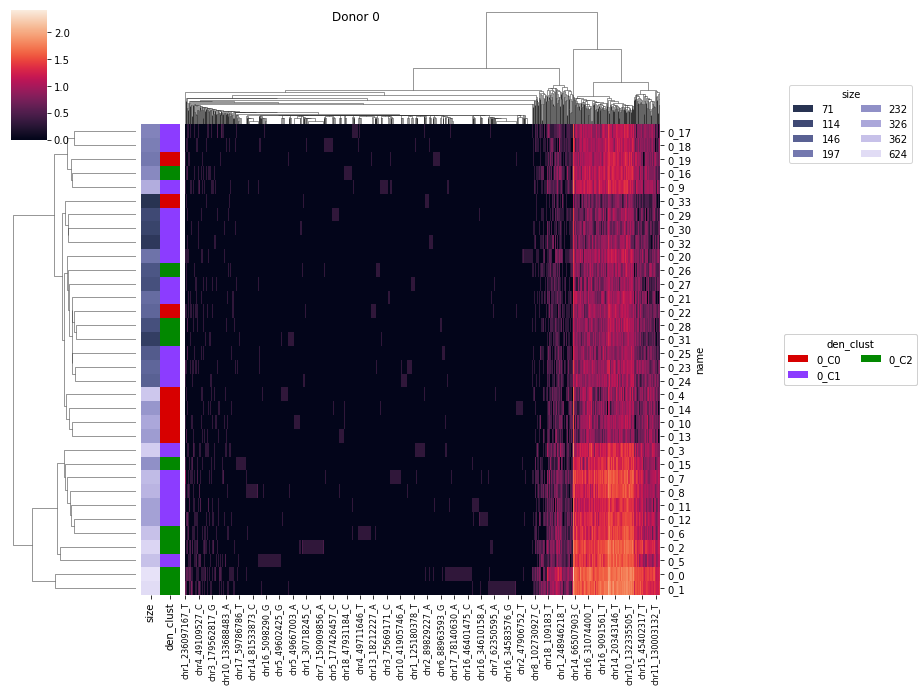

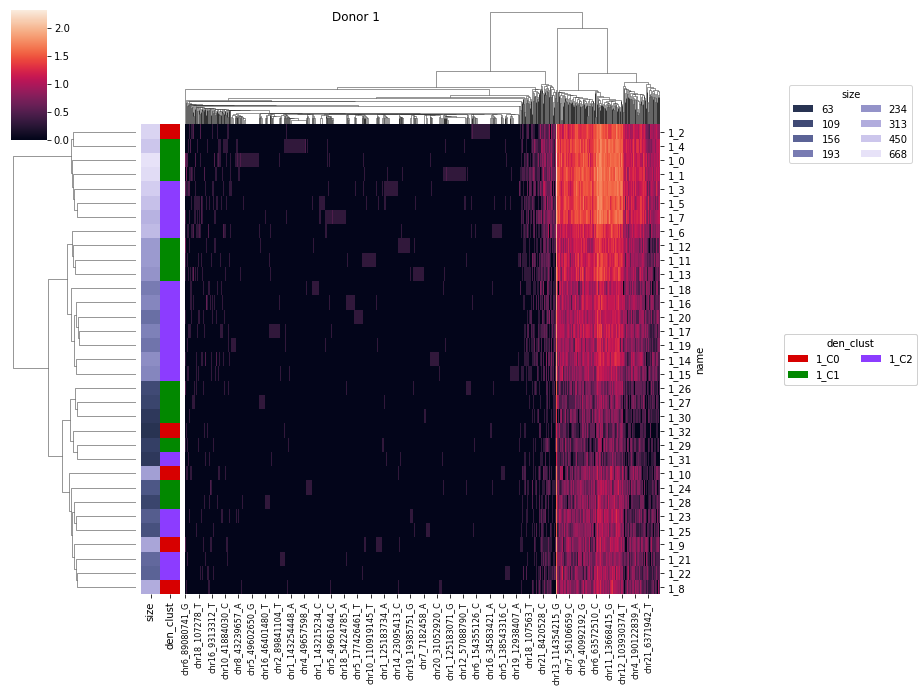

In [18]:
for d, curr_cl in clones.groupby("donor"):
    print('d', d)
    curr_som = clone_som_merge_df.loc[clone_som_merge_df.index.isin(curr_cl.index)]
    curr_som = curr_som.loc[:, ~((curr_som==0).all())]
    print('curr_som', curr_som.shape)
    if curr_som.shape[0] == 1:
        f = plt.figure()
        sns.heatmap(np.log10(curr_som+1))
    else:
        ch.plot_cluster(np.log10(curr_som+1), row_meta=curr_cl.drop("donor",axis=1), 
                   row_clr_schemes={"size":"sequential", "den_clust": "categorical", "donor":"categorical"})

    plt.suptitle(f"Donor {d}")
    #fu.helper_save(join(outdir, f"donor{d}_som_vars_dendro.png"), to_pdf=False)
    #fu.helper_save(join(outdir, f"donor{d}_som_vars_dendro.png"), to_pdf=False)

In [ ]:
from scipy.stats import fisher_exact

def fish_test(variant_ser, clone_id, clones_meta):
    x_pos = variant_ser.loc[clone_id]

    x_neg = curr_cl.loc[clone_id, 'size'] - x_pos
    
    y_pos = sum(variant_ser.loc[variant_ser.index!=clone_id])
    y_neg = curr_cl['size'].sum() - x_pos - x_neg - y_pos
#     print('clone_id', clone_id)
#     print('var', variant_ser.name)
#     print(f"cells in clone with var: {x_pos} ; cells in clone: {x_neg}")
#     print(f"cells not in clone with var: {y_pos};  cells not in clone: {y_neg} ")
    oddsratio, pval = fisher_exact([[x_pos,x_neg],[y_pos,y_neg]], alternative='greater')
    return pval

def clone_fish(var_ser, clones_meta):
    #print(var_ser)
    pval_ser = pd.Series(index=var_ser.index, dtype=float)
    for curr_cl in var_ser.index:
        pval_ser.loc[curr_cl] = fish_test(var_ser, curr_cl, clones_meta)
    #print(pval_ser)
    return pval_ser.fillna(1)

def var_fish(df, clones_meta):
    pval_df = df.apply(clone_fish, args=(clones_meta,), axis=0)
    return pval_df


pval_df = var_fish(curr_som, curr_cl)

In [35]:
pval_df

,chr5_49659903_G,chr18_108100_C,chr2_89839644_C,chr14_91060931_C,chr16_46390036_T
name,,,,,
1_0,0.548490,0.947350,0.389889,0.909834,0.800073
1_1,0.779732,0.893095,0.480286,0.537706,0.719534
1_10,1.000000,0.749324,0.696716,1.000000,0.973920
1_11,0.804336,0.366358,0.180309,0.059980,0.362946
1_12,0.355256,0.248830,0.551963,0.165309,0.898423
1_13,0.651637,0.271682,0.742343,0.012185,0.322795
1_14,0.119336,0.729071,0.969609,0.962029,0.776637
1_15,0.013667,0.261899,0.913815,0.706836,0.190931
1_16,0.009237,0.113809,0.389994,0.853477,0.046280


## Normalize to clone size

d 0
curr_som (34, 1026)
d 1
curr_som (33, 970)


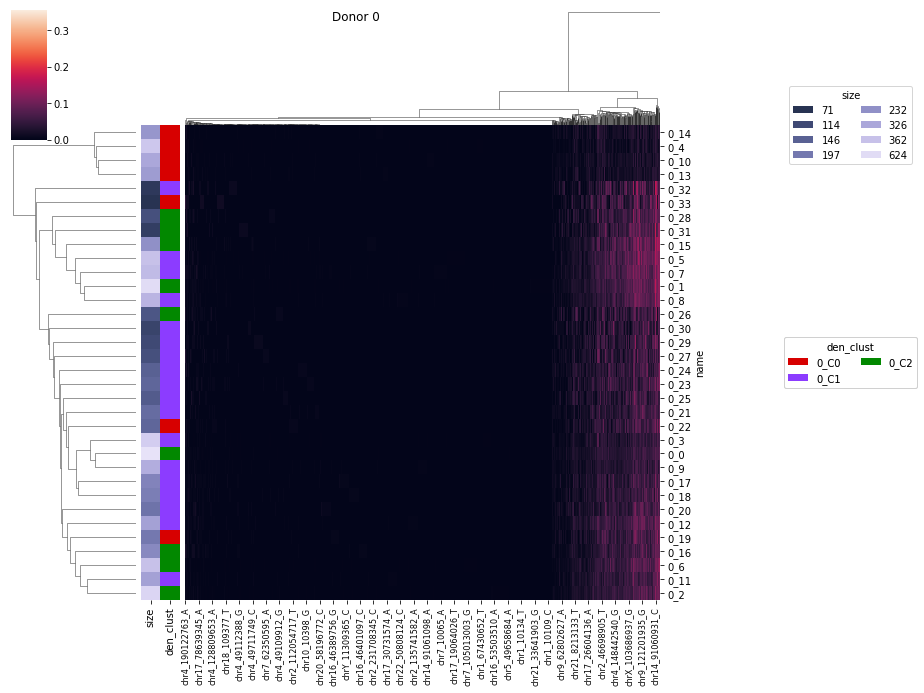

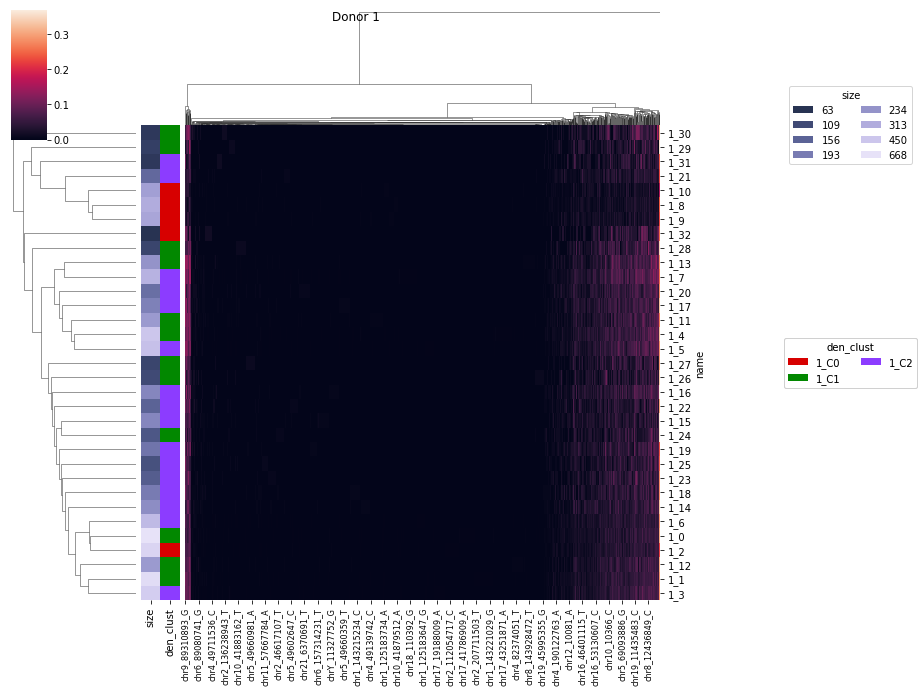

In [12]:
for d, curr_cl in clones.groupby("donor"):
    print('d', d)
    curr_som = clone_som_merge_df.loc[clone_som_merge_df.index.isin(curr_cl.index)]
    curr_som = curr_som.apply(lambda x: x/curr_cl.loc[x.name,"size"], axis=1)
    curr_som = curr_som.loc[:, ~((curr_som==0).all())]
    curr_som
    print('curr_som', curr_som.shape)
    if curr_som.shape[0] == 1:
        f = plt.figure()
        sns.heatmap(curr_som)
    else:
        ch.plot_cluster(curr_som, row_meta=curr_cl.drop("donor",axis=1),
                   row_clr_schemes={"size":"sequential", "den_clust": "categorical", "donor":"categorical"})

    plt.suptitle(f"Donor {d}")
    #fu.helper_save(join(outdir, f"norm_donor{d}_som_vars_dendro.png"), to_pdf=False)

# Calculate enrichment for each clone
A. Fisher's exact test for variant in clone vs not (account for clone sizes)  
B. Remove variants seen in >50% of clones    
C. Entropy for the variant num cells in each clone  
C. Rank by (%Cells in clone with variant)/(%cells not in clone with variant) .. calculate percent by adding pseudocount of 1 to both
